In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.engine.topology import Input
from keras.layers import MaxPooling1D,GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D,Dense,Dropout,regularizers
from keras.models import Model,load_model
from keras import optimizers
import h5py # necessary for saving keras model
import numpy as np
import pickle
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,classification_report

/Applications/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.layers import Concatenate,GaussianNoise

In [3]:
# first we need to download glove.840B according to README
# load pretrained word embeddings:glove.840B.300d.txt

filename = 'glove.840B.300d.txt' ## this file 'glove.840B.300d.txt' is composed of lines with each line containning a word and its embedding.

## store words and their embeddings in separate lists, then turn embedding list to np array.

def loadGloVe(filename):
    vocab = []
    embd = []
    #with open (filename,'r') as f:
        #emb_size = len(f.readline().strip().split(' '))-1
    #vocab.append('unk') #load unknown words
    #embd.append([0]*emb_size)
    
    file = open(filename,'r')
    for line in file:
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd

vocab,embd = loadGloVe(filename)
vocab_size = len(vocab)
embedding_dim = len(embd[0])

Loaded GloVe!


In [5]:
print (vocab_size,embedding_dim)

2196017 300


In [3]:
# load preprocessed data before vecortization
with open("Preprocessed data for CNN - update.txt",'rb') as f:
    texts_train_ls = pickle.load(f)
    texts_test_ls = pickle.load(f)
    labels_train = pickle.load(f)
    labels_test = pickle.load(f)
print (len(texts_train_ls))
print (len(texts_test_ls))
print (len(labels_train))
print (len(labels_test)) 

11314
7532
11314
7532


In [4]:
# build vocabulary of the text; elementary vectorization.
num_words = 20000
max_length = 300

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts (texts_train_ls)
sequences_train = tokenizer.texts_to_sequences(texts_train_ls)
sequences_test = tokenizer.texts_to_sequences(texts_test_ls)

data_train = pad_sequences(sequences_train,maxlen = max_length)
data_test = pad_sequences(sequences_test,maxlen = max_length)

word_index = tokenizer.word_index
print (len(word_index.items()))

133927


In [5]:
targets_train = to_categorical(labels_train)
targets_test = to_categorical(labels_test)

In [10]:
# build embedding matrix
embedding_matrix = np.zeros((num_words+1,embedding_dim))

for word,index in word_index.items(): # word_index start with index one, not zero.
    if index > num_words:
        continue
    if word not in vocab:
        continue
    else:
        embedding_matrix[index] = embd[vocab.index(word)]

In [13]:
with open("embedding_matrix-840B.txt",'wb') as f1:
    pickle.dump(embedding_matrix,f1)

In [9]:
with open("embedding_matrix-840B.txt",'rb') as f1:
    embedding_matrix = pickle.load(f1)

In [10]:
# build embedding layer
embedding_layer_d = Embedding(num_words+1,300,weights = [embedding_matrix],input_length = data_train.shape[1],trainable = True)

In [6]:
# split the original train set into a new train set and a validation set
X_train_d,X_val_d,y_train_d,y_val_d = train_test_split(data_train,targets_train,test_size = 0.2,random_state = 42)

In [14]:
# build the model
# filter_sizes = (2,3,4,5),l2=1e-5, pooling = GlobalMaxPooling+GlobalAvgPooling
sequence_input = Input(shape = (data_train.shape[1],),dtype = 'int32')
embedded_input = embedding_layer_d(sequence_input)

input_x = GaussianNoise(stddev = 0.01)(embedded_input)

x1 = Conv1D(128,2,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,4,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x4 = Dropout(0.5)(x4)

x11 = GlobalMaxPooling1D()(x1)# 128 dim vector
x21 = GlobalMaxPooling1D()(x2) # 128 dim vector
x31 = GlobalMaxPooling1D()(x3) # 128 dim vector
x41 = GlobalMaxPooling1D()(x4) # 128 dim vector

x12 = GlobalAveragePooling1D()(x1)# 128 dim vector
x22 = GlobalAveragePooling1D()(x2) # 128 dim vector
x32 = GlobalAveragePooling1D()(x3) # 128 dim vector
x42 = GlobalAveragePooling1D()(x4) # 128 dim vector

x = Concatenate(axis=-1)([x11,x12,x21,x22,x31,x32,x41,x42])
x = Dropout(0.5)(x)

preds = Dense(y_train_d.shape[1], activation='softmax',kernel_regularizer = regularizers.l2(1e-5))(x)

model_d = Model(sequence_input,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_d.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_1_d = model_d.fit(X_train_d,y_train_d,batch_size = 128,epochs = 40,validation_data=(X_val_d, y_val_d))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 184s 20ms/step - loss: 2.1387 - acc: 0.4098 - val_loss: 1.1058 - val_acc: 0.8126
Epoch 2/40
9051/9051 [==============================] - 186s 21ms/step - loss: 0.7964 - acc: 0.7560 - val_loss: 0.7676 - val_acc: 0.8471
Epoch 3/40
9051/9051 [==============================] - 189s 21ms/step - loss: 0.5245 - acc: 0.8428 - val_loss: 0.6032 - val_acc: 0.8780
Epoch 4/40
9051/9051 [==============================] - 187s 21ms/step - loss: 0.3635 - acc: 0.8992 - val_loss: 0.5193 - val_acc: 0.8917
Epoch 5/40
9051/9051 [==============================] - 190s 21ms/step - loss: 0.2654 - acc: 0.9245 - val_loss: 0.4460 - val_acc: 0.9001
Epoch 6/40
9051/9051 [==============================] - 193s 21ms/step - loss: 0.2118 - acc: 0.9400 - val_loss: 0.4129 - val_acc: 0.9050
Epoch 7/40
9051/9051 [==============================] - 187s 21ms/step - loss: 0.1653 - acc: 0.9556 - val_loss: 0.3775 - val_acc: 

In [ ]:
model_d.save("Model_3-TextCNN-Glove.840B-1e-5-1") # 9231 36th, 9209 40th

In [28]:
loaded_model = load_model("Model_3-TextCNN-Glove.840B-1e-5-1")
config_d = loaded_model.get_config()
weights_d = loaded_model.get_weights()
config_d["layers"][21]["config"]["kernel_regularizer"]["config"]["l2"] = 1e-4

model_d_L2_up = Model.from_config(config_d) # the only change is: increasing l2 from 1e-5 to 1e-4 due to sign of overfitting
model_d_L2_up.set_weights(weights_d)

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#
model_d_L2_up.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_up_1_d = model_d_L2_up.fit(X_train_d,y_train_d,batch_size = 128,epochs = 40,validation_data=(X_val_d, y_val_d))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 189s 21ms/step - loss: 0.0173 - acc: 0.9975 - val_loss: 0.3402 - val_acc: 0.9205
Epoch 2/40
9051/9051 [==============================] - 183s 20ms/step - loss: 0.0145 - acc: 0.9982 - val_loss: 0.3348 - val_acc: 0.9218
Epoch 3/40
9051/9051 [==============================] - 184s 20ms/step - loss: 0.0152 - acc: 0.9982 - val_loss: 0.3359 - val_acc: 0.9209
Epoch 4/40
9051/9051 [==============================] - 185s 20ms/step - loss: 0.0148 - acc: 0.9977 - val_loss: 0.3450 - val_acc: 0.9178
Epoch 5/40
9051/9051 [==============================] - 184s 20ms/step - loss: 0.0134 - acc: 0.9983 - val_loss: 0.3442 - val_acc: 0.9200
Epoch 6/40
9051/9051 [==============================] - 184s 20ms/step - loss: 0.0134 - acc: 0.9982 - val_loss: 0.3545 - val_acc: 0.9107
Epoch 7/40
9051/9051 [==============================] - 184s 20ms/step - loss: 0.0108 - acc: 0.9988 - val_loss: 0.3377 - val_acc: 

In [29]:
model_d_L2_up.save("Model_3-TextCNN-Glove.840B-1e-5-2") # 9262 30th 9258 25th 9253 34th

In [30]:
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_d_L2_up.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_up_2_d = model_d_L2_up.fit(X_train_d,y_train_d,batch_size = 128,epochs = 40,validation_data=(X_val_d, y_val_d))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 246s 27ms/step - loss: 0.0030 - acc: 0.9999 - val_loss: 0.3259 - val_acc: 0.9205
Epoch 2/40
9051/9051 [==============================] - 249s 28ms/step - loss: 0.0033 - acc: 0.9997 - val_loss: 0.3227 - val_acc: 0.9227
Epoch 3/40
9051/9051 [==============================] - 245s 27ms/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.3177 - val_acc: 0.9218
Epoch 4/40
9051/9051 [==============================] - 187s 21ms/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.3228 - val_acc: 0.9249
Epoch 5/40
9051/9051 [==============================] - 186s 21ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.3176 - val_acc: 0.9240
Epoch 6/40
9051/9051 [==============================] - 185s 20ms/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.3217 - val_acc: 0.9240
Epoch 7/40
9051/9051 [==============================] - 185s 20ms/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.3157 - val_acc: 

In [31]:
model_d_L2_up.save("Model_3-TextCNN-Glove.840B-1e-5-3") # 9249 4th 18th

In [35]:
optimizer = optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=None)#
model_d_L2_up.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_up_3_d = model_d_L2_up.fit(X_train_d,y_train_d,batch_size = 128,epochs = 40,validation_data=(X_val_d, y_val_d))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 190s 21ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.9222
Epoch 2/40
9051/9051 [==============================] - 198s 22ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3097 - val_acc: 0.9249
Epoch 3/40
9051/9051 [==============================] - 195s 21ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.3055 - val_acc: 0.9222
Epoch 4/40
9051/9051 [==============================] - 199s 22ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3062 - val_acc: 0.9222
Epoch 5/40
9051/9051 [==============================] - 197s 22ms/step - loss: 0.0015 - acc: 0.9999 - val_loss: 0.3076 - val_acc: 0.9231
Epoch 6/40
9051/9051 [==============================] - 192s 21ms/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.3035 - val_acc: 0.9222
Epoch 7/40
9051/9051 [==============================] - 194s 21ms/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.3079 - val_acc: 

In [36]:
model_d_L2_up.save("Model_3-TextCNN-Glove.840B-1e-5-4") # 9249 2th 12th

In [92]:
def draw_performance(history_list,n_epochs_per_hs):
# history_list: list of histories
# n_epochs_per_hs: the number of epochs per history

    hs_keys = list(history_list[0].history.keys())
    labels = hs_keys
    clr = ['r','orange','green','b']
    fig = plt.figure(figsize = (16,9))
    n_epochs = n_epochs_per_hs * len(history_list)

    for i in range(len(history_list)):
        for j,key in enumerate(hs_keys): 
            plt.plot(range(i*n_epochs_per_hs,(i+1)*n_epochs_per_hs),history_list[i].history[key],clr[j])
    plt.legend(labels)
    plt.grid(True,linestyle = "-",color = 'k',linewidth = 0.1)
    plt.xticks(np.arange(0,n_epochs,10))
    plt.yticks(np.arange(0,3,0.1))
    
    plt.show()

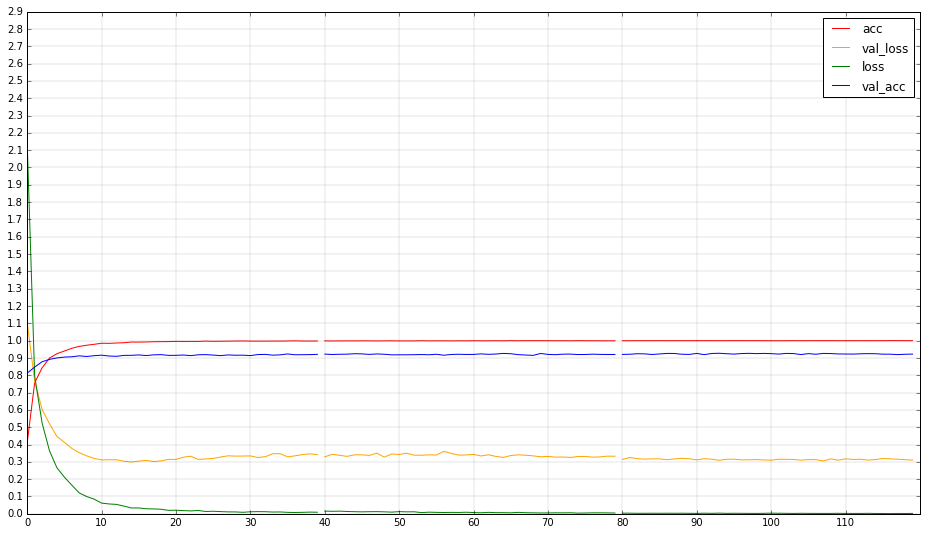

In [29]:
# The following graph shows performance of the first 120 epochs of the model
history_list = [hs_1_d,hs_up_1_d,hs_up_2_d]
n_epochs_per_hs = 40

draw_performance(history_list,n_epochs_per_hs)

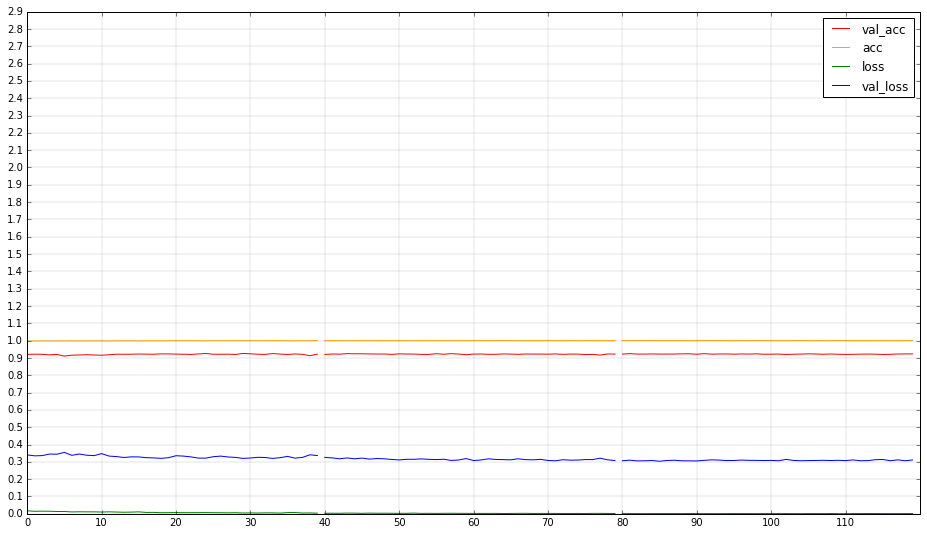

In [93]:
# The following graph shows performance of the model from epoch 41.
history_list = [hs_up_1_d,hs_up_2_d,hs_up_3_d]
n_epochs_per_hs = 40

draw_performance(history_list,n_epochs_per_hs)

## Evaluation

In [38]:
# split the test dataset into two part, so as to compare whether the model gives similar performance on different test data.
X_test_1 = data_test[:int(len(data_test)*0.4)]
X_test_2 = data_test[int(len(data_test)*0.4):]

y_test_1 = targets_test[:int(len(data_test)*0.4)]
y_test_2 = targets_test[int(len(data_test)*0.4):]

In [78]:
def test(model,X1,y1,X2,y2):
    acc1 = model.evaluate(X1,y1)[1]
    acc2 = model.evaluate(X2,y2)[1]
    acc_avg = acc1*0.4 + acc2*0.6
    
    return acc1,acc2,acc_avg

In [94]:
model_test = load_model("Model_3-TextCNN-Glove.840B-1e-5-4")

In [95]:
test(model_test,X_test_1,y_test_1,X_test_2,y_test_2)

4520/4520 [==============================] - 19s 4ms/step


(0.850265604249668, 0.856858407079646, 0.8542212859476548)